<br/>
$$ \huge{\underline{\textbf{ 1-Layer Neural Network }}} $$
<br/>

# Introduction

Main purpose of this notebook is to provide **consolidated graph view, math notation** and **python code** along with links to relevant proofs.

Presented neural network contains only one layer (output). While code in the notebook can support any number of neurons, both examples have single neuron. In this notebook I demonstrate simplest possible neural network, hence I will use mean squared error loss function and full gradient descent (train on whole dataset all at once).

I realise technically we should use cross entropy loss (better convergence) and stochastic gradient descent (speed). These will be presented in future notebooks. Datasets used in this notebook are simple and small, so neither really matters.

We are going to take **computational graph approach**. While it's possible to analyse small neural nets directly, computational graphs provide scalable mental framework to analyse and implement very deep and complex neural nets. They allows us to define forward operations and derive backpropagation formulas **one operation at a time**. Resulting implementation will be similarly modular. This will be indispensable when working with deeper, more complex architectures (convnets, recurrent, etc.). Intuitive introduction to computational graphs in this [video from CS231n](https://www.youtube.com/watch?v=d14TUNcbn1k&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=4)

**Contents**

* [Neural Network](#Neural-Network) - neural net, backprop, train function
* [Example 1](#Example-1:Logical-AND) - logical AND problem
* [Example 2](#Example-2:-College-Admissions) - college admissions problem

**Model**

* one layer: **fully connected** with **sigmoid** activation
* loss: **mean squared error**
* optimizer: **gradient descent**

**Recommended Reading**

* [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/) by Michael Nilsen - great introductory book on neural nets, free
* [Computational Graphs](https://www.youtube.com/watch?v=d14TUNcbn1k&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=4) video from CS231n - introduction to computational graphs and why use them
* [CS231n](http://cs231n.github.io/) - lecture notes from famous Stanford deep learning course

**Notation**

| math | python | shape | comment |
|-|-|-|-|
| - | n_dataset | int | size of train dataset (\*) |
| $n_\text{batch}$ | n_batch | int | size of mini-batch (\*) |
| $n_\text{in}$ | n_in | int | number of input features |
| $n_\text{out}$ | n_out | int | number of outputs (\*\*) |
| $x$ | x | (n_batch, n_in)  | inputs to model |
| $W$ | W | (n_in, n_out) | weights |
| $b$ | b | (1, n_out) | biases |
| $z$ | z | (n_batch, n_out) | preactivations |
| $y$ | y | (n_batch, n_out) | targets |
| $\hat{y}$ | y_hat | (n_batch, n_out) | model outputs [0..1] |
| $\sigma(z)$ | sigmoid() | - | sigmoid function |
| $\sigma'(z)$ | sigmoid_der() | - | sigmoid derivative |
| $J(y, \hat{y})$ | loss() | scalar | loss function |

* (\*) - for simplicity we feed in whole dataset all at once, so in this notebook n_batch and n_dataset are always equal
* (\*\*) - in this notebook *n_out* is always one, but depending on problem, model could have more than one output

# Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Overview**

Assuming *single training example*, two inputs and one output our neural network will look as follows

<img src="assets/perceptron.png">

Both input and output matrices would be single row

$$
x = 
\overset{\text{← n_in →}}{
  \begin{bmatrix}
  x_{11} & x_{12} \\
  \end{bmatrix}
}
\quad\quad\quad
\hat{y} =
\overset{\text{← n_out →}}{
  \begin{bmatrix}
  \ \ \hat{y}_{11} \ \ \\ 
  \end{bmatrix}
}
$$

Input matrix $x$ is arranged such that each **training example** occupies **single row**.

<u>Row vs Column Arragement</u>

Most (all?) modern frameworks (TensorFlow, Keras, PyTorch) reserve first dimension of input tensor to be mini-batch, which in 2d case results in training examples being arranged into rows in the code. To the best of my memory all real-world code (i.e. not educational) that I have seen follows this convention. I would like my notebooks to be compatible, and I like math notation to reflect code 1:1, hence I will use one-training-example-per-row arrangement everywhere.

Alternative arrangement is to have training examples in columns. For example Michael Nilsen book and initial parts of Andrew Ng Deep Learning course use such arrangement. Andrew Ng course switches to row-arrangement in later exercises which use Keras. Of course actual information flow and results achieved are identical disregarding of which arrangement is being used.

**Sigmoid**

Sigmoid activation function and its derivate - both computed element wise. Derivative proof e.g. [here](https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x)

$$ \sigma(z) = \frac{1}{1+\epsilon^{-z}} \quad\quad\quad\quad \sigma'(z) = \sigma(z)(1-\sigma(z)) \tag{eq. 1} $$

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))    # result can be cached during forward pass and reused here for speed

**Forward Pass**

All variables are 2d arrays. $x$, $W$ and $b$ denote input mini-batch, weights and biases respectively. *n_batch* is size of mini-batch, but in this notebook we always feed full dataset all at once. *n_in, n_out* are number of input features and number of outputs from the model (in this notebook nb_out is always one). $\hat{y}$ is output from the model.

Formulas

$$ z = xW + b \tag{eq 2}$$

$$ \hat{y} = \sigma(z) \tag{eq 3}$$

As computational graph

<img src="assets/0010_diag_fwd.png"/>

@ denotes matrix multiplication

In [3]:
def forward(x, W, b):                #                                      x.shape (n_batch, n_in)
    z = x @ W + b                    # @ is matmul, b is broadcasted        z.shape: (n_batch, n_out)
    return sigmoid( z )              #                                      shape: (n_batch, n_out)

**Loss**

$J(y,\hat{y})$ is a loss function and it outputs a scalar. As mentioned before, we are using mean squared error loss function. Note that I sum over outputs and average only over batch size. Alternative is to average over both. It will change magnitude of loss values which will change magnitude of gradients. This doesn't make much difference in practice as we simply compensate with learning rate. But this is potentially important when e.g. trying to reproduce a paper, you might want to either match the method, or adjust learning rate accordingly to match results.

The ½ at the beginning cancels out in derivative. In this notebook it is necessary because we do numerical gradient checks. Otherwise it can be omitted.

Loss

$$ J(y,\hat{y}) = \frac{1}{2} \frac{1}{n_\text{batch}} \sum_{t=1}^{n_\text{batch}}  \ \sum_{k=1}^{n_\text{out}} \  (y_{tk} - \hat{y}_{tk})^2 \tag{eq 4} $$

In [4]:
def loss(y, y_hat):                                   #                      y_hat, y.shape: (n_batch, n_out)
    result = np.sum( (y-y_hat)**2, axis=-1 )          # sum over outputs     result.shape: (n_batch, 1)
    return .5 * np.mean( result )                     # average over batch   shape: scalar

**Backpropagation**

At each backprop step we want to update parameters $W$ and $b$ slightly to make output error (loss $J$) smaller. To do this efficiently we will compute corresponding derivatives $\frac{\partial J}{\partial W}$ and $\frac{\partial J}{\partial b}$. Both derivatives are matrices with shapes matching corresponding variables. I.e. $\frac{\partial J}{\partial W}$ is always the same shape as $W$. Elements of $\frac{\partial J}{\partial W}$ tell us how 'wiggling' corresponding element $W$ would affect output $J$.

Matrix calculus is beyond the scope of this notebook, good resources include:

* [Multivariable Calculus](https://www.khanacademy.org/math/multivariable-calculus) at Khan Academy - intro and basics
* [Computational Graphs](https://www.youtube.com/watch?v=d14TUNcbn1k&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=4) video from CS231n - introduction to computational graphs and why use them
* [The Matrix Calculus You Need For Deep Learning](https://arxiv.org/abs/1802.01528) - proper treatment of matrix calculus for deep learning
* [Backpropagation for a Linary Layer](http://cs231n.stanford.edu/handouts/linear-backprop.pdf) and [Derivatives, Backpropagation, and Vectorization](http://cs231n.stanford.edu/handouts/derivatives.pdf) - detailed treatment of backprop through matrix multiplication

Note: one could obtain derivatives by calculating them one-element-at-a-time (like e.g. [here](https://theclevermachine.wordpress.com/2014/09/06/derivation-error-backpropagation-gradient-descent-for-neural-networks/)). This is good to know, but works only for small neural nets.

Lets have a look at computational graph

<img src="assets/0010_diag_back.png"/>

From the multivariable chain rule we obtain

$$ 
\frac{\partial J}{\partial W} = \frac{\partial J}{\partial \hat{y}}   \frac{\partial \hat{y}}{\partial z}   \frac{\partial z}{\partial W} 
$$

Note that $\frac{\partial J}{\partial \hat{y}}$ is derivative of scalar wrt matrix, which in itself is a matrix (easy peasy). But $\frac{\partial \hat{y}}{\partial z}$ and $\frac{\partial z}{\partial W}$ are both derivatives of matrix wrt matrix, which are 4d-tensors (not so easy peasy). Thankfully we don't have to (and will not) compute these explicitly. Instead at each backprop step we compute derivative of $J$ wrt intermediate variable (e.g. $\hat{y}$ or $z$) directly going deeper and deeper until we reach $W$ and $b$.

Backprop through loss function ([proof](#Proofs))

$$\frac{\partial J}{\partial \hat{y}} = \frac{1}{n_\text{batch}} (\hat{y} - y) \tag{eq 5}$$

Backprop through sigmoid - sigmoid is element wise, so combination ends up being element-wise (symbol $*$)

$$\frac{\partial J}{\partial z} =
\frac{\partial J}{\partial \hat{y}}  \frac{\partial \hat{y}}{\partial z} =
\frac{\partial J}{\partial \hat{y}} * \sigma'(z)  \tag{eq 6}$$

Backprop through linear combination ([proof](http://cs231n.stanford.edu/handouts/linear-backprop.pdf))

$$\frac{\partial J}{\partial W} =
\frac{\partial J}{\partial z}  \frac{\partial z}{\partial W} =
x^T \big(\frac{\partial J}{\partial z}\big)  \tag{eq 7}$$

Backprop into bias $b$ - because $b$ was broadcasted across batch there are multiple pathways it affects output. As per total derivative chain rule, we need to sum contributions over all pathways. This also makes shapes match.

$$
\frac{\partial J}{\partial b} = \sum_{t=1}^{n_\text{batch}} \frac{\partial J}{\partial z_k}  \tag{eq 8}
$$

**Train Loop**

This function contains everything. Pass in full dataset (inputs x, targets y) and randomly initialized weights $W$ and biases $b$. Because example problems in this notebook are very small, this function trains on whole dataset all at once, i.e. it doesn't pick mini-batches. $W$ and $b$ are updated in-place.

In [5]:
def train_classifier(x, y, nb_epochs, learning_rate, W, b):
    """Params:
        x - inputs  - shape: (n_dataset, n_in)
        y - targets - shape: (n_dataset, n_out)
        nb_epochs - number of full passes over dataset
        W - weights, modified in place - shape: (nb_in, nb_out)
        b - biases, modified in place  - shape: (1, nb_out)
    Note: in this notebook nb_out is always equal to one
    """
    losses = []                                                 # keep track of losses for plotting

    for e in range(nb_epochs):
                
        # Forward Pass
        z = x @ W + b                                           # (eq 2)    z.shape: (batch_size, nb_neurons)
        y_hat = sigmoid(z)                                      # (eq 3)    y_hat.shape: (batch_size, nb_neurons)
        
        # Backward Pass
        rho = (y_hat-y) / len(x) * sigmoid_der(z)               # (eq 5, 6) backprop through MSE and sigmoid
        dW = (x.T @ rho)                                        # (eq 7)    backprop through matmul
        db = np.sum(rho, axis=0, keepdims=True)                 # (eq 8)    backprop into b
        
        # Gradient Check (defined at the end of the notebook)
        # ngW, ngb = numerical_gradient(x, y, W, b)
        # assert np.allclose(ngW, dW) and np.allclose(ngb, db)

        # Update weights
        W += -learning_rate * dW
        b += -learning_rate * db

        # Log and Print
        loss_train = loss(y, y_hat)                             # binary cross-entropy
        losses.append(loss_train)                               # save for plotting
        if e % (nb_epochs / 10) == 0:
            print('loss ', loss_train.round(4))
            
    return losses

This concludes neural network definition.

# Example 1: Logical AND

Mapping we are trying to learn:

| $x_1$ | $x_2$ | → | $y$ |
|---|---|---|--|
| 0 | 0 | → | 0 |
| 0 | 1 | → | 0 |
| 1 | 0 | → | 0 |
| 1 | 1 | → | 1 |

Dataset

In [6]:
# training examples   x1   x2
x_train = np.array([[0.0, 0.0],
                    [0.0, 1.0],
                    [1.0, 0.0],
                    [1.0, 1.0]])

# training targets    y
y_train = np.array([[0.0],
                    [0.0],
                    [0.0],
                    [1.0]])

Create neural network (Xavier initialization explained quite well [here](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization))

In [7]:
# Hyperparams
nb_epochs = 2000
learning_rate = 1

# Initialize
np.random.seed(0)                                                             # for reproducibility
nb_inputs, nb_outputs = 2, 1                                                  # 2 input columns, 1 output per example
W = np.random.normal(scale=1/nb_inputs**.5, size=[nb_inputs, nb_outputs])     # Xavier init
b = np.zeros(shape=[1, nb_outputs])                                           # ok to init biases to zeros

Before training, with randomly initialized $W$

In [8]:
y_hat = forward(x_train, W, b).round(2)
print('x1, x2      target     model ')
print('[0, 0]   →   [0]      ', y_hat[0])
print('[0, 1]   →   [0]      ', y_hat[1])
print('[1, 0]   →   [0]      ', y_hat[2])
print('[1, 1]   →   [1]      ', y_hat[3])

x1, x2      target     model 
[0, 0]   →   [0]       [0.5]
[0, 1]   →   [0]       [0.57]
[1, 0]   →   [0]       [0.78]
[1, 1]   →   [1]       [0.82]


Train neural network

In [9]:
losses = train_classifier(x_train, y_train, nb_epochs, learning_rate, W, b)

loss  0.1513
loss  0.0271
loss  0.0153
loss  0.0103
loss  0.0077
loss  0.006
loss  0.005
loss  0.0042
loss  0.0036
loss  0.0032


After training

In [10]:
y_hat = forward(x_train, W, b).round(2)
print('x1, x2      target     model ')
print('[0, 0]   →   [0]      ', y_hat[0])
print('[0, 1]   →   [0]      ', y_hat[1])
print('[1, 0]   →   [0]      ', y_hat[2])
print('[1, 1]   →   [1]      ', y_hat[3])

x1, x2      target     model 
[0, 0]   →   [0]       [0.]
[0, 1]   →   [0]       [0.08]
[1, 0]   →   [0]       [0.08]
[1, 1]   →   [1]       [0.9]


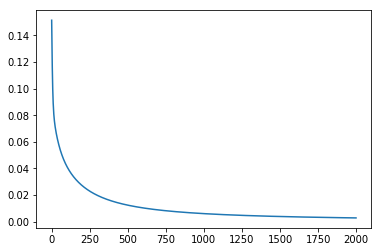

In [11]:
plt.plot(losses)

# Example 2: College Admissions

**Dataset**

We will use graduate school admissions data ([https://stats.idre.ucla.edu/stat/data/binary.csv]()). Each row is one student. Columns are as follows:
* admit - was student admitted or not? This is our target we will try to predict
* gre - student GRE score
* gpa - student GPA
* rank - prestige of undergrad school, 1 is highest, 4 is lowest

Extra Imports

In [12]:
import pandas as pd

Loda data with pandas

In [13]:
df = pd.read_csv('college_admissions.csv')

Show first couple rows. First column is index, added automatically by pandas.

In [14]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Show some more information about dataset.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


Plot data, each rank separately

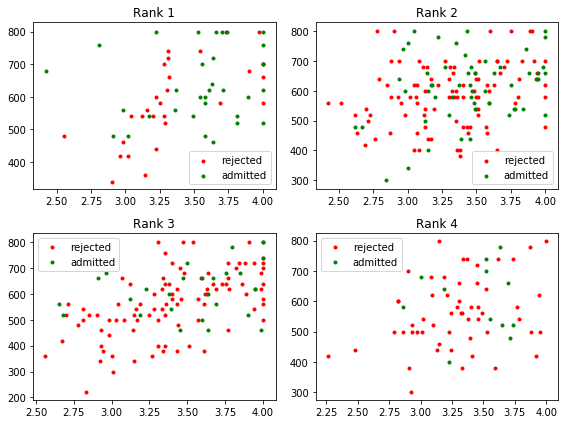

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8,6])
axes = axes.flatten()
for i, rank in enumerate([1,2,3,4]):
    # pick not-admitted students with given rank
    tmp = df.loc[(df['rank']==rank) & (df['admit']==0)]
    axes[i].scatter(tmp['gpa'], tmp['gre'], color='red', marker='.', label='rejected')
    # pick admitted students with given rank
    tmp = df.loc[(df['rank']==rank) & (df['admit']==1)]
    axes[i].scatter(tmp['gpa'], tmp['gre'], color='green', marker='.', label='admitted')
    axes[i].set_title('Rank '+str(rank))
    axes[i].legend()
fig.tight_layout()

#### Preprocess

Code below does following things:
* convert _rank_ column into one-hot encoded features
* normalize _gre_ and _gpa_ columns to zero mean and unit standard deviation
* splits of 20% of data as test set
* splits into input features (gre, gpa, one-hot-rank) and targets (admit)
* convert into numpy
* assert shapes are ok

In [17]:
# Create dummies
temp = pd.get_dummies(df['rank'], prefix='rank')
data = pd.concat([df, temp], axis=1)
data.drop(columns='rank', inplace=True)

# Normalize
for col in ['gre', 'gpa']:
    mean, std = data[col].mean(), data[col].std()
    # data.loc[:, col] = (data[col]-mean) / std
    data[col] = (data[col]-mean) / std

# Split off random 20% of the data for testing
np.random.seed(0)
sample = np.random.choice(data.index, size=int(len(data)*0.9), replace=False)
data, test_data = data.iloc[sample], data.drop(sample)

# Split into features and targets
features_train = data.drop('admit', axis=1)
targets_train =  data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

# Convert to numpy
x_train = features_train.values            # features train set (numpy)
y_train = targets_train.values[:,None]     # targets train set (numpy)
x_test = features_test.values              # features validation set (numpy)
y_test = targets_test.values[:,None]       # targets validation set (numpy)

# Assert shapes came right way around
assert x_train.shape == (360, 6)
assert y_train.shape == (360, 1)
assert x_test.shape == (40, 6)
assert y_test.shape == (40, 1)

#### Train Classifier

Create neural network

In [18]:
# Hyperparams
nb_epochs = 2000
learning_rate = 1

# Initialize
np.random.seed(0)                                                       # for reproducibility
n_inputs, n_outputs = x_train.shape[1], 1                               # get dataset shape
W = np.random.normal(scale=n_inputs**-.5, size=[n_inputs, n_outputs])   # Xavier init
b = np.zeros(shape=[1, n_outputs])

Train

In [19]:
losses = train_classifier(x_train, y_train, nb_epochs, learning_rate, W, b)

loss  0.1524
loss  0.0974
loss  0.0973
loss  0.0972
loss  0.0972
loss  0.0972
loss  0.0972
loss  0.0972
loss  0.0972
loss  0.0972


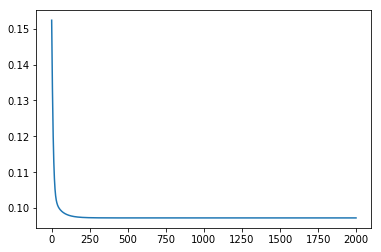

In [20]:
plt.plot(losses)

In [21]:
pred = forward(x_train, W, b)
pred = pred > 0.5
acc = np.mean(pred == y_train)
print('Accuracy on training set (expected ~0.71):', acc.round(2))

Accuracy on training set (expected ~0.71): 0.71


In [22]:
pred = forward(x_test, W, b)
pred = pred > 0.5
acc = np.mean(pred == y_test)
print('Accuracy on test set (expected ~0.75):', acc.round(2))

Accuracy on test set (expected ~0.75): 0.75


Note: accuracy on test set is usually worse than training set. College admissions dataset is very small and I think we just got lucky with easy test set when splitting into train/test sets.

# Numerical Gradient Check

Run this cell if you want to perform numerical gradient check in train_classifier()

In [23]:
def numerical_gradient(x, y, W, b):
    """Check gradient numerically"""
    assert W.ndim == 2
    assert b.ndim == 2
    assert b.shape[0] == 1
    
    eps = 1e-4
    
    # Weights
    del_W = np.zeros_like(W)    
    for r in range(W.shape[0]):
        for c in range(W.shape[1]):
            W_min = W.copy()
            W_pls = W.copy()
            
            W_min[r, c] -= eps
            W_pls[r, c] += eps
            
            y_hat_pls = forward(x, W_pls, b)
            y_hat_min = forward(x, W_min, b)
            
            l_pls = loss(y, y_hat_pls)
            l_min = loss(y, y_hat_min)

            del_W[r, c] = (l_pls - l_min) / (eps * 2)
            
    # Biases
    del_b = np.zeros_like(b)
    for c in range(b.shape[1]):
        b_min = b.copy()
        b_pls = b.copy()
            
        b_min[0, c] -= eps
        b_pls[0, c] += eps
            
        y_hat_pls = forward(x, W, b_pls)
        y_hat_min = forward(x, W, b_min)
            
        l_pls = loss(y, y_hat_pls)
        l_min = loss(y, y_hat_min)

        del_b[0, c] = (l_pls - l_min) / (eps * 2)
    
    return del_W, del_b

In [24]:
def test_gradients():
    n_batch = 100
    n_in = 10
    n_out = 10
    for i in range(100):
        x = np.random.randn(n_batch, n_in)
        y = np.random.randn(n_batch, n_out)
        W = np.random.randn(n_in, n_out)
        b = np.random.randn(1, n_out)

        # Forward Pass
        z = x @ W + b                                           # (eq 2)    z.shape: (batch_size, nb_neurons)
        y_hat = sigmoid(z)                                      # (eq 3)    y_hat.shape: (batch_size, nb_neurons)
        # Backward Pass
        rho = (y_hat-y) / len(x) * sigmoid_der(z)               # (eq 5, 6) backprop through MSE and sigmoid
        dW = (x.T @ rho)                                        # (eq 7)    backprop through matmul
        db = np.sum(rho, axis=0, keepdims=True)                 # (eq 8)    backprop into b

        ngW, ngb = numerical_gradient(x, y, W, b)

        assert np.allclose(dW, ngW)
        assert np.allclose(db, ngb)
test_gradients()

# Proofs

**Backprop through mean squared error**

Forward pass

$$ J(y,\hat{y}) = \frac{1}{2} \frac{1}{\text{n_batch}} \sum_{t=1}^{\text{n_batch}}  \ \sum_{k=1}^{\text{n_out}} \  (y_{tk} - \hat{y}_{tk})^2 $$

Proof: let's take one element $\frac{\partial J}{\partial \hat{y}_{ij}}$, where $i$ is number of training example and $j$ is input feature

$$ 
\frac{\partial J}{\partial \hat{y}_{ij}} \ = \
\frac{\partial}{\partial \hat{y}_{ij}} \big[    \frac{1}{2} \frac{1}{\text{n_batch}} \sum_{t=1}^{\text{n_batch}}  \ \sum_{k=1}^{\text{n_out}} \  (y_{tk} - \hat{y}_{tk})^2 \big]
\tag*{drop sums i≠t and j≠k}
$$

$$
\\ \overset{\text{}}{=} \
\frac{1}{2} \frac{1}{\text{n_batch}}  \  \frac{\partial}{\partial \hat{y}_{ij}}  (y_{ij} - \hat{y}_{ij})^2
\tag*{chain rule}
$$

$$
\\ = \
\frac{1}{\text{n_batch}} (y_{ij} - \hat{y}_{ij} )(-1)
$$

$$
\\ = \
\frac{1}{\text{n_batch}} (\hat{y}_{ij} - y_{ij} )  \tag*{combine elements}
$$

$$
\frac{\partial J}{\partial \hat{y}} = \frac{1}{\text{n_batch}} (\hat{y} - y )
$$

We can drop both sums because output $\hat{y}_{ij}$ depends only on $\hat{y}_{tk}$ where $i=t, j=k$. Note that $y$ and $\hat{y}$ are swapped at the end due to minus sign. At the last step we can combine $\frac{\partial J}{\partial \hat{y}_{ij}}$ back into single matrix $\frac{\partial J}{\partial \hat{y}}$